<a href="https://colab.research.google.com/github/swethaswetha7676/023_BDA_assignment/blob/main/23_BDA_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Build a Clustering Model with Spark with a datset of your choise***

Description:
1. Setup: The code first prepares the environment by importing necessary libraries for data processing, clustering, and visualization. It also initializes a Spark session, which is like starting up a powerful engine for data analysis.
2. Data Loading and Preparation: It loads the Iris dataset, which contains information about different iris flowers. Then, it selects the relevant features (like petal length and width) and transforms them into a format suitable for the clustering algorithm. This involves scaling the features so they have similar ranges.
3. Clustering: The core of the process is using the K-means algorithm to group the iris flowers into clusters based on their features. The algorithm aims to find clusters where flowers within a cluster are more similar to each other than to flowers in other clusters.
4. Evaluation: After clustering, the code evaluates how well the algorithm performed. It uses a metric called the Silhouette score to assess the quality of the clusters. A higher score indicates better-defined clusters.
5. Visualization: To understand the results visually, the code creates plots showing the clusters in 2D and 3D space. These plots help in visualizing how the flowers are grouped based on their features and the predicted clusters.
6. Cleanup: Finally, the code closes the Spark session, releasing the resources used during the analysis.

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

In [ ]:
# Initialize Spark Session
spark = SparkSession.builder \
    .appName("IrisClustering") \
    .getOrCreate()

# Load the Iris dataset
file_path = "/content/Iris (1).csv"  # Update this path if needed
iris_df = spark.read.csv(file_path, header=True, inferSchema=True)

# Show the schema and sample data
print("Schema:")
iris_df.printSchema()
print("\nSample data:")
iris_df.show(5)

Schema:
root
 |-- Id: integer (nullable = true)
 |-- SepalLengthCm: double (nullable = true)
 |-- SepalWidthCm: double (nullable = true)
 |-- PetalLengthCm: double (nullable = true)
 |-- PetalWidthCm: double (nullable = true)
 |-- Species: string (nullable = true)


Sample data:
+---+-------------+------------+-------------+------------+-----------+
| Id|SepalLengthCm|SepalWidthCm|PetalLengthCm|PetalWidthCm|    Species|
+---+-------------+------------+-------------+------------+-----------+
|  1|          5.1|         3.5|          1.4|         0.2|Iris-setosa|
|  2|          4.9|         3.0|          1.4|         0.2|Iris-setosa|
|  3|          4.7|         3.2|          1.3|         0.2|Iris-setosa|
|  4|          4.6|         3.1|          1.5|         0.2|Iris-setosa|
|  5|          5.0|         3.6|          1.4|         0.2|Iris-setosa|
+---+-------------+------------+-------------+------------+-----------+
only showing top 5 rows

Silhouette with squared euclidean distance = 0.

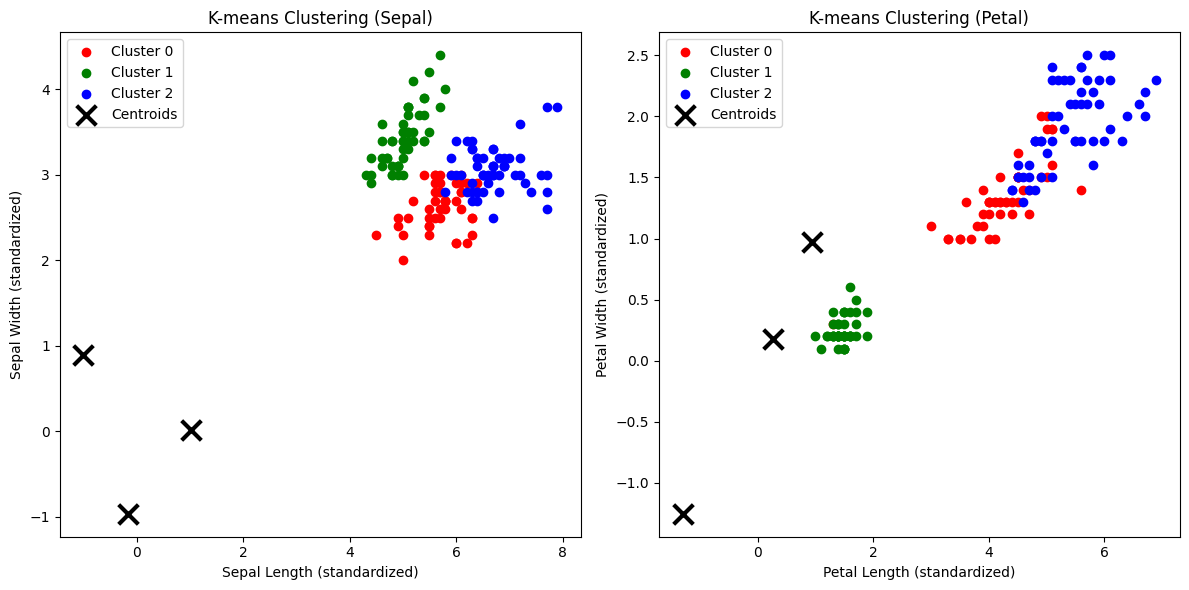

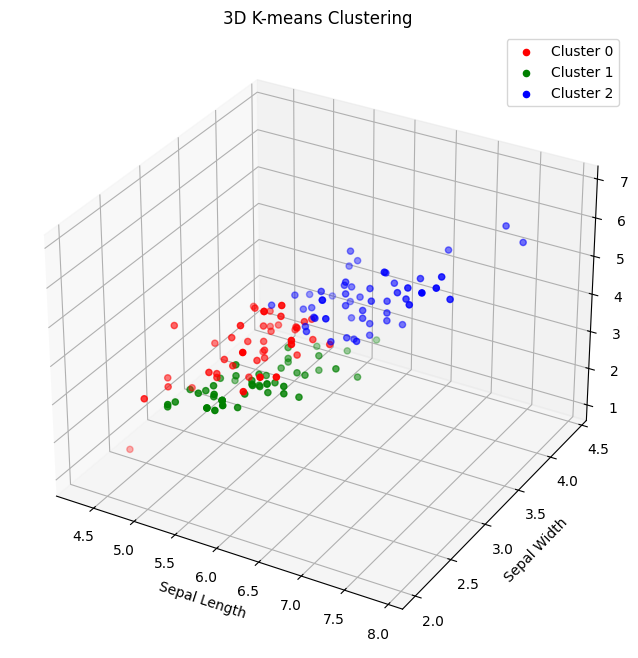

In [ ]:
# Prepare features - exclude id and Species columns
feature_columns = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
features_df = assembler.transform(iris_df)

# Standardize the features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=True)
scaler_model = scaler.fit(features_df)
scaled_data = scaler_model.transform(features_df)

# Train K-means model
kmeans = KMeans(featuresCol="scaledFeatures", k=3, seed=42)
model = kmeans.fit(scaled_data)

# Make predictions
predictions = model.transform(scaled_data)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator(featuresCol="scaledFeatures")
silhouette = evaluator.evaluate(predictions)
print(f"Silhouette with squared euclidean distance = {silhouette:.3f}")

# Show the cluster centers
print("Cluster Centers:")
centers = model.clusterCenters()
for i, center in enumerate(centers):
    print(f"Cluster {i}: {center}")

# Compare clusters with actual species
print("\nCluster distribution by actual species:")
predictions.groupBy("prediction", "Species").count().orderBy("prediction").show()

# Collect data for visualization
pd_df = predictions.select('SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm', "Species", "prediction").toPandas()

# Create 2D visualization (Sepal Length vs Sepal Width)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
colors = ['red', 'green', 'blue']
for i in range(3):
    plt.scatter(pd_df[pd_df['prediction'] == i]['SepalLengthCm'],
                pd_df[pd_df['prediction'] == i]['SepalWidthCm'],
                c=colors[i], label=f'Cluster {i}')
plt.scatter(np.array(centers)[:, 0], np.array(centers)[:, 1], marker='x', s=200, linewidths=3, color='black', label='Centroids')
plt.xlabel('Sepal Length (standardized)')
plt.ylabel('Sepal Width (standardized)')
plt.title('K-means Clustering (Sepal)')
plt.legend()

# Create 2D visualization (Petal Length vs Petal Width)
plt.subplot(1, 2, 2)
for i in range(3):
    plt.scatter(pd_df[pd_df['prediction'] == i]['PetalLengthCm'],
                pd_df[pd_df['prediction'] == i]['PetalWidthCm'],
                c=colors[i], label=f'Cluster {i}')
plt.scatter(np.array(centers)[:, 2], np.array(centers)[:, 3], marker='x', s=200, linewidths=3, color='black', label='Centroids')
plt.xlabel('Petal Length (standardized)')
plt.ylabel('Petal Width (standardized)')
plt.title('K-means Clustering (Petal)')
plt.legend()

plt.tight_layout()
plt.savefig('kmeans_2d_clusters.png')
plt.show()

# Create 3D visualization
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

for i in range(3):
    ax.scatter(pd_df[pd_df['prediction'] == i]['SepalLengthCm'],
               pd_df[pd_df['prediction'] == i]['SepalWidthCm'],
               pd_df[pd_df['prediction'] == i]['PetalLengthCm'],
               c=colors[i], label=f'Cluster {i}', depthshade=True)

ax.set_xlabel('Sepal Length')
ax.set_ylabel('Sepal Width')
ax.set_zlabel('Petal Length')
ax.set_title('3D K-means Clustering')
plt.legend()
plt.savefig('kmeans_3d_clusters.png')
plt.show()

# Stop Spark session
spark.stop()